# CNN
This notebook aims to deploy the CNN.

## Setup for UCloud
The Setup on Ucloud is a bit feasty at times, so here are some workarounds

In [53]:
#pip freeze > requirements.txt

In [54]:
!pip install -r requirements.txt
!pip install matplotlib opencv-python pandas scikit-learn tensorflow
!pip install numpy==1.26.4 --force-reinstall
!pip install editdistance

# scipy
!pip install --upgrade --force-reinstall --no-cache-dir scipy
!pip install --upgrade --force-reinstall --no-cache-dir scikit-learn


Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
Defaulting to user installation because normal site-packages is not writea

In [55]:
!sudo apt-get update
!sudo apt-get install -y libgl1
# !sudo apt-get -y upgrade
# git clone git@github.com:LinusLinuxer/SPECIALIZATION-PROEJECT.git


Hit:1 http://archive.ubuntu.com/ubuntu noble InRelease
Hit:2 http://archive.ubuntu.com/ubuntu noble-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu noble-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu noble-security InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.7.0-1build1).
0 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from editdistance import eval as edit_distance  

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import ctc_decode



2025-05-22 12:24:14.940272: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 12:24:15.074783: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 12:24:15.160584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747909455.247901   79963 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747909455.271692   79963 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747909455.455187   79963 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

---
## Loading the data
Data has to load out of the 'carolianminuscule-groundtruth'-folder 

In [2]:
def get_images(folder_path: str):
    """
    Load images and text files from the given path.
    :param folder_path: Path to the directory containing images and text files.
    :return: Two lists - one for image paths and one for text file paths.
    """
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Path {folder_path} does not exist.")

    images = []
    files = []

    for entry in os.listdir(folder_path):
        entry_path = os.path.join(folder_path, entry)
        if os.path.isdir(entry_path):
            # Recursively get images and text files from subdirectories
            sub_images, sub_files = get_images(entry_path)
            images.extend(sub_images)
            files.extend(sub_files)
        elif entry.endswith(".png"):
            images.append(entry_path)
        elif entry.endswith(".txt"):
            files.append(entry_path)

    return images, files


# load the data from the directory
path = "carolineminuscule-groundtruth"
images, files = get_images(path)


# matched the .png- and .txt-file in a folder together
matched_list_path = [
    [img, file]
    for img in images
    for file in files
    if os.path.dirname(img) == os.path.dirname(file)
    and os.path.splitext(os.path.splitext(os.path.basename(img))[0])[0]
    == os.path.splitext(os.path.splitext(os.path.basename(file))[0])[0]
]


In [3]:
print(f"len matched: {len(matched_list_path)}")
print(f"matched_list:\n {matched_list_path[1]}")

len matched: 429
matched_list:
 ['carolineminuscule-groundtruth/bsb00095929/0011/010002.bin.png', 'carolineminuscule-groundtruth/bsb00095929/0011/010002.gt.txt']


---
## Creating the Dataset

In [4]:
# define a dataframe to store the image, image paths and their corresponding text files
df = pd.DataFrame(columns=["name", "image", "transcription"])

for i, (img_path, file_path) in enumerate(matched_list_path):
    # read the image
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img = np.array(img)
    # add the image to the dataframe, set "none" here to add transcription later
    df.loc[i] = [os.path.basename(img_path), img, None]
    # read the text file
    with open(file_path, "r") as f:
        # read the transcription
        transcription = f.read()
    # add the transcription to the dataframe
    df.loc[i, "transcription"] = transcription

In [5]:
# delete all the linebrakes in the transcription
df["transcription"] = df["transcription"].str.replace("\n", "", regex=False)
df.head(5)

,name,image,transcription
0,010005.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",initio sicuti pleriq; studio ad empabacan
1,010002.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",gla memores que s quis: faciliafacto putat
2,010007.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",pro abstinentia ꝓuirtute audacia. largitio. au...
3,010008.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",bant. Quę tametsianimus aspꝑnabatur. insolens ...
4,010017.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",tilinę coniuratione quam uerissime potero paucis


For now it appear that the images only have "255" as values, i.e. white. That's why im checking for other values. But the edges of the images are all white, therefore this is the exspected behaviour.

In [6]:
non_255_values = df['image'].apply(lambda img: np.any(img != 255))
print(f"Rows  in 'image' with values other than 255: {non_255_values.sum()}")

Rows  in 'image' with values other than 255: 429


In [7]:
is_unique = df["name"].is_unique
print(f"Are the values in 'name' unique? {is_unique}")

Are the values in 'name' unique? False


In [8]:
# Find duplicated values in the 'name' column
duplicated_names = df[df["name"].duplicated(keep=False)]["name"]
print("Non-unique values in 'name':")
print(duplicated_names.unique())
print(f"Sum of non-unique item: {len(duplicated_names.unique())}")

Non-unique values in 'name':
['010005.bin.png' '010002.bin.png' '010007.bin.png' '010008.bin.png'
 '010017.bin.png' '01000a.bin.png' '010019.bin.png' '010011.bin.png'
 '010010.bin.png' '01000e.bin.png' '010001.bin.png' '01001a.bin.png'
 '010013.bin.png' '010003.bin.png' '010015.bin.png' '010009.bin.png'
 '010014.bin.png' '01000c.bin.png' '01000b.bin.png' '010004.bin.png'
 '01000d.bin.png' '01001b.bin.png' '010012.bin.png' '010006.bin.png'
 '010018.bin.png' '01000f.bin.png' '010016.bin.png' '01001c.bin.png']
Sum of non-unique item: 28


In [9]:
# Check if the values in the 'name' column are unique
# If not, make them unique by appending a counter to duplicates

def make_unique(names):
    counts = {}
    result = []
    for name in names:
        if name not in counts:
            counts[name] = 0
            result.append(name)
        else:
            counts[name] += 1
            result.append(f"{name}.{counts[name]}")
    return result

df["name"] = make_unique(df["name"])
is_unique = df["name"].is_unique
print(f"Are the values in 'name' unique? {is_unique}")

Are the values in 'name' unique? True


In [10]:
# Find duplicated values in the 'name' column
duplicated_names = df[df["name"].duplicated(keep=False)]["name"]
print("Non-unique values in 'name':")
print(duplicated_names.unique())
print(f"Sum of non-unique item: {len(duplicated_names.unique())}")

Non-unique values in 'name':
[]
Sum of non-unique item: 0


---
## Preparing the data

By calculating the maximum and avg. number of the height we can use that value later in our CNN.

In [11]:
# Calculate the maximum and average width of the lists in the 'image' column
image_heigth = df["image"].apply(lambda img: img.shape[0])  # Height of each image
max_height = image_heigth.max()
avg_height = image_heigth.mean()
quantile_height = image_heigth.quantile(0.95)

# Calculate the maximum and average width of the lists in the 'image' column
image_width = df["image"].apply(lambda img: img.shape[1])  # Width of each image
max_width = image_width.max()
avg_width = image_width.mean()
quantile_width = image_width.quantile(0.95)

print(f"Maximum height of an image: {max_height}")
print(f"Average height of an image: {int(avg_height)}")
print(f"95% quantile height: {int(quantile_height)}")
print(f"Maximum width of an image: {int(max_width)}")
print(f"Average width of an image: {int(avg_width)}")
print(f"95% quantile width: {int(quantile_width)}")

Maximum height of an image: 263
Average height of an image: 140
95% quantile height: 193
Maximum width of an image: 3058
Average width of an image: 1938
95% quantile width: 2902


In [12]:
# Features (images) and labels (transcriptions)
X = df["image"].values          # Images as NumPy arrays
y = df["transcription"].values  # Transcriptions as strings

In [13]:
# Convert images to NumPy arrays and normalize
X = np.array(
    [cv2.resize(img, (2048, 256)) for img in df["image"]], dtype=np.float32
)  # Resize and convert to float32

print(f"X shape: {X.shape}, dtype: {X.dtype}")

X shape: (429, 256, 2048), dtype: float32


In [14]:
# find the length of the transcription
# aplly different measures

transcription_lengths = df["transcription"].apply(len)
print("Transcription lengths:")
print(f"Max length:\t\t {int(transcription_lengths.max())}")
print(f"Mean length:\t\t {int(transcription_lengths.mean())}")
print(f"95%-Quantile:\t\t {int(transcription_lengths.quantile(0.95))}")

Transcription lengths:
Max length:		 70
Mean length:		 46
95%-Quantile:		 65


In [15]:
# Create a character-to-index mapping
charset = sorted(set("".join(df["transcription"])))  # Unique characters in the dataset
char_to_index = {char: idx for idx, char in enumerate(charset)}
index_to_char = {idx: char for char, idx in char_to_index.items()}
num_classes = len(charset) + 1  # Add 1 for the blank character (CTC loss)


# Convert transcriptions to sequences of integers
label_sequences = [
    [char_to_index[char] for char in transcription]
    for transcription in df["transcription"]
]

# Pad sequences to a fixed length
max_sequence_length = 256   

# Pads the sequences to the same length
padded_labels = pad_sequences(
    label_sequences, maxlen=max_sequence_length, padding="post", value=num_classes - 1
)

print(f"Character set: {charset}")
print(f"Number of classes: {num_classes}")
print(f"Character to index mapping: {char_to_index}")
print(f"y shape: {y.shape}, dtype: {y.dtype}")

Character set: [' ', '&', "'", '*', ',', '.', '/', '1', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', 'á', 'ã', 'æ', 'é', 'õ', 'ú', 'ā', 'ć', 'đ', 'ē', 'ę', 'ĩ', 'ī', 'ń', 'ō', 'ś', 'ũ', 'ū', 'ǣ', 'ǵ', 'ḿ', 'ẽ', 'ꝑ', 'ꝓ', 'ꝗ', 'ꝙ', 'ꝛ', 'ꝝ']
Number of classes: 84
Character to index mapping: {' ': 0, '&': 1, "'": 2, '*': 3, ',': 4, '.': 5, '/': 6, '1': 7, ':': 8, ';': 9, '?': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E': 15, 'F': 16, 'H': 17, 'I': 18, 'K': 19, 'L': 20, 'M': 21, 'N': 22, 'O': 23, 'P': 24, 'Q': 25, 'R': 26, 'S': 27, 'T': 28, 'U': 29, 'V': 30, 'X': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'x': 52, 'y': 53, 'z': 54, 'á': 55, 'ã': 56, 'æ': 57, 'é': 5

In [16]:
# Convert transcriptions to sequences of integers
label_sequences = [
    [char_to_index[char] for char in transcription]
    for transcription in df["transcription"]
]

# Pad sequences to a fixed length (use a value outside the valid character indices, like num_classes - 1 for blank)
padded_labels = pad_sequences(
    label_sequences, maxlen=max_sequence_length, padding="post", value=num_classes - 1
)

# Convert to NumPy array, not one-hot encoded because CTC loss expects integer sequences
y = np.array(padded_labels, dtype=np.int32)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_classes = len(charset) + 1  # Number of unique characters. +1 for the blank character (CTC loss)

In [18]:
print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")

X_train shape: (343, 256, 2048), dtype: float32
y_train shape: (343, 256), dtype: int32


---
## Data visualisation
Below I want to gain a better understanding of our datapoints

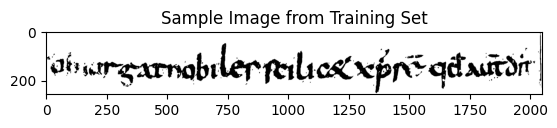

In [19]:
show_img_nr = 1

plt.imshow(X_train[show_img_nr], cmap="gray", vmin=0, vmax=255)
plt.title("Sample Image from Training Set")
plt.show()

In [20]:
print("First entry in y_train:")
print(y_train[show_img_nr])

First entry in y_train:
[32 33  0 50 40 47 38 32 49 43 44 33 40 41 36 48  0 48 34 40 41 40 34  1
  0 52 45  3 48 34  3  0 46 63  0 32 50 49  3  0 35 40 49  3 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83]


In [21]:
# Translate the first entry in y_train back to text using index_to_char
decoded_text = "".join(
    [index_to_char[idx] for idx in y_train[show_img_nr] if idx < len(index_to_char)]
)
print(decoded_text)

ab uirgatnobiles scilic& xp*sc* qđ aut* dit*


---

## Evaluation metric

In [22]:
# evaluation metrics
eval_metrics = pd.DataFrame(columns=["epoch", "ctc loss", "val_loss", "cer", "wer"])


class MetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, index_to_char):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.index_to_char = index_to_char

    def on_epoch_end(self, epoch, logs=None):
        # Predict on validation set
        y_pred = self.model.predict(self.X_val)
        decoded_sequences, _ = tf.keras.backend.ctc_decode(
            y_pred, input_length=np.ones(y_pred.shape[0]) * y_pred.shape[1]
        )
        y_pred_texts = [
            "".join(
                self.index_to_char.get(
                    idx, ""
                )  # Robust gegen -1 oder ungültige Indizes
                for idx in seq.numpy()
            )
            for seq in decoded_sequences[0]
        ]

        y_true_texts = [
            "".join(
                self.index_to_char[idx] for idx in seq if idx < len(self.index_to_char)
            )
            for seq in self.y_val
        ]
        cer = MetricsLogger.character_error_rate(y_true_texts, y_pred_texts)
        wer = MetricsLogger.word_error_rate(y_true_texts, y_pred_texts)

        # Log metrics
        self.log_metrics(epoch, logs, cer, wer)
        eval_metrics.to_csv("eval_metrics.csv", index=True)

    def log_metrics(self, epoch, logs, cer, wer):
        eval_metrics.loc[epoch] = [
            epoch,
            logs.get("ctc_loss", logs.get("loss")),
            logs.get("val_loss"),
            cer,
            wer,
        ]

    @staticmethod
    def character_error_rate(y_true, y_pred):
        total_edits = 0
        total_chars = 0
        for true, pred in zip(y_true, y_pred):
            total_edits += edit_distance(true, pred)
            total_chars += len(true)
        return total_edits / total_chars if total_chars > 0 else 0.0

    @staticmethod
    def word_error_rate(y_true, y_pred):
        total_edits = 0
        total_words = 0
        for true, pred in zip(y_true, y_pred):
            total_edits += edit_distance(true.split(), pred.split())
            total_words += len(true.split())
        return total_edits / total_words if total_words > 0 else 0.0

    def ctc_loss(y_true, y_pred):
        """
        Compute the CTC (Connectionist Temporal Classification) loss between the true and predicted labels.

        Args:
            y_true: Ground truth labels (padded sequences).
            y_pred: Predicted label probabilities from the model.

        Returns:
            Tensor representing the CTC loss for the batch.
        """
        # Calculate the length of each input sequence (all sequences are assumed to be the same length here)
        input_length = (
            tf.ones(shape=(tf.shape(y_pred)[0], 1), dtype=tf.int32)
            * tf.shape(y_pred)[1]
        )
        # Calculate the length of each label sequence (all sequences are assumed to be the same length here)
        label_length = (
            tf.ones(shape=(tf.shape(y_true)[0], 1), dtype=tf.int32)
            * tf.shape(y_true)[1]
        )
        # Compute the CTC batch cost using Keras backend
        return tf.keras.backend.ctc_batch_cost(
            y_true, y_pred, input_length, label_length
        )

---
## Training


In [25]:
cnn_rnn = models.Sequential(
    [
        # CNN layers
        # input shape is = (height, width, channels)
        layers.Conv2D(
            64, (3, 3), padding="same", activation="relu", input_shape=(256, 2048, 1)
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),  # → (128, 1024, 64)
        layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),  # → (64, 512, 128)
        # reshape for RNN
        layers.Reshape(target_shape=(512, 64 * 128)),  # (batch, 512, 8192)
        # RNN layers
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        # Output layer
        layers.Dense(
            num_classes, activation="softmax"
        ),  # Use softmax for probabilities
    ]
)

cnn_rnn.compile(optimizer="adam", loss=MetricsLogger.character_error_rate)

# cnn_rnn.summary()

2025-05-22 12:27:52.174889: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-05-22 12:27:52.215799: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-05-22 12:27:52.237714: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-05-22 12:27:52.354028: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2025-05-22 12:27:52.385720: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


In [ ]:
#! Commented out to avoid running the model training
# # Fit the model
# When fitting the model, pass validation data and index_to_char to the callback:
# cnn_rnn.fit(
#     X_train,
#     y_train,
#     epochs=10,
#     validation_data=(X_test, y_test),
#     batch_size=16,
#     callbacks=[MetricsLogger(X_test, y_test, index_to_char)]
# )

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 549.8674WARNING:tensorflow:5 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f73e04f9940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f73e04f9940> triggered tf.function r

In [79]:
eval_metrics.head()

,epoch,ctc loss,val_loss,cer,wer
0,0.0,404.394714,277.094940,0.979602,1.0
1,1.0,281.796478,271.480591,0.979602,1.0
2,2.0,277.406982,265.539185,0.979602,1.0
3,3.0,275.408264,263.565033,0.979602,1.0
4,4.0,273.792725,261.629181,0.979602,1.0


In [81]:
cnn_rnn.save("CNN_RNN_model.keras")